# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

In [38]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

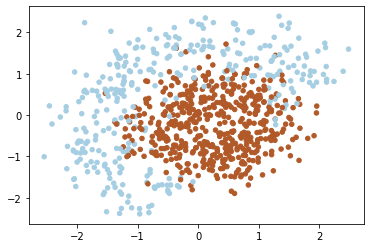

In [39]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [266]:
# y.shape

(826,)

In [8]:
# X.shape

(826, 2)

### Общие положения данной работы:

1. Каждый блок домашки проверялся на правильность через проверочный код, который я позаимстовал в оригинальном ноутбуке ШАДовского курса по ссылке выше. Не стал его убирать, так может быть проще проверить работу и кое-где проследить ход моей мысли.
2. Для более быстрого исполнения кода можно убрать в реализации каждого градиента первый вызов функции visualize в цикле (но так красиво и наглядно видна работа классификатора, мне нравится)
3. Дополнительно Был реализован Адам в самой базовой его конструкции, остальные было реализовывать лень.
4. В целом, с каждым следующим алгоритмом лосс падает немного лучше, но его падение становится более "рванным", менее "плавным" и стабильным.

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [40]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    
    # ваш код здесь
    X_new = np.c_[ X, np.zeros([X.shape[0], 3])] 
    X_new = np.c_[ X_new, np.ones([X.shape[0], 1])]
    for string in range(X_new.shape[0]):
        X_new[string, :][2] = X_new[string, :][0]**2
        X_new[string, :][3] = X_new[string, :][1]**2
        X_new[string, :][4] = X_new[string, :][0] * X_new[string, :][1]
    return X_new
    

#### Самопроверка

In [41]:
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

In [42]:
dummy_expanded = expand(dummy_X)

In [43]:
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])


In [44]:
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")

Seems legit!


### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [45]:
def probability(X, w):
    """
    Принимает на вход расширенную матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей [0,1] для каждого наблюдения/объекта [n_samples]
    """
    
    # ваш код здесь
    P = 1 / (1 + np.exp(-X @ w)) # -X @ w
#     P = 1/(1 + np.ravel(np.exp(-X @ w.reshape(-1, 1)))) # -X @ w
    return P

#### Самопроверка

In [46]:
dummy_weights = np.linspace(-1,1,6)

In [47]:
dummy_probs = probability(dummy_expanded,dummy_weights)

In [48]:
dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

In [49]:
assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [50]:
def compute_loss(X, y, w):
    """
    Принимает на вход расширенную матрицу фичей (объекты-признаки), вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь (число!), расчитанное по формуле выше.
    """
         
    # ваш код здесь
#     X_exp = expand(X)
#     L = -np.mean(y*np.log(probability(X_exp, w)) + (1-y)*np.log(1 - probability(X_exp, w)))
    L = -np.mean(y*np.log(probability(X, w)) + (1-y)*np.log(1 - probability(X, w)))
    return L

#### Самопроверка

In [51]:
dummy_y = np.array([0,1,0,1])

dummy_loss = compute_loss(dummy_expanded,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [52]:
def compute_grad(X, y, w):
    """
    Находит значение градиента.
    Given feature matrix X [n_samples,2], target vector y [n_samples],
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    # ваш код здесь
    P = probability(X, w)
    grad = -np.mean((y - P)* X.T, axis=1)
    return grad # вектор градиентов размерности [6]
    

#### Самопроверка

In [53]:
dummy_expanded # X_ext - расширенная матрица объекты-признаки (фичи) [4*6]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
       [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
       [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

In [54]:
dummy_weights # w - веса [6]

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [55]:
P = probability(dummy_expanded, dummy_weights) # вероятность принадлежать определенному классу для каждого объекта [4]
P

array([0.73105858, 0.450166  , 0.02020883, 0.59844257])

In [56]:
dummy_y # y_true - истинные ответы для каждого наблюдения/объекта [4]

array([0, 1, 0, 1])

In [57]:
#tests
dummy_grads = compute_grad(dummy_expanded,dummy_y,dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

Функция ниже предназначена для визуализации процесса обучения. 

In [58]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

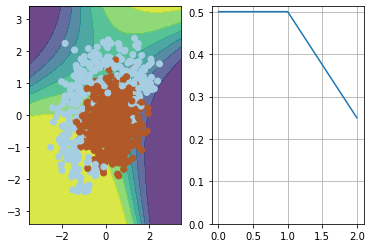

In [59]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



In [576]:
#  X_exp[np.random.choice(X_exp.shape[0], size=batch_size, replace=True)]

In [569]:
# np.random.choice(X_exp.shape[0], batch_size)

array([699, 115, 190, 252])

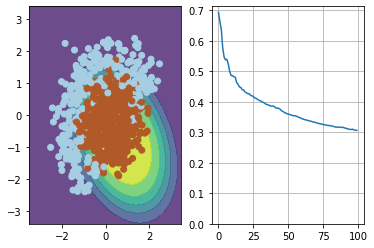

<Figure size 432x288 with 0 Axes>

In [60]:
np.random.seed(42)

eta = 0.1 

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


w = np.array([0, 0, 0, 0, 0, 1])
X_exp = expand(X)


for i in range(n_iter):
    ind = np.random.choice(X_exp.shape[0], batch_size)
    loss[i] = compute_loss(X_exp, y, w)
    visualize(X_exp[ind,:], y[ind], w, loss)
    w = w.astype(dtype='float64') - eta*compute_grad(X_exp[ind,:], y[ind], w)

    
visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


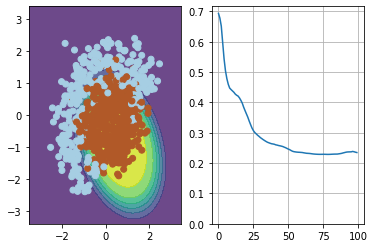

<Figure size 432x288 with 0 Axes>

In [61]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate

alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_exp.shape[0], batch_size)
    loss[i] = compute_loss(X_exp, y, w)
    visualize(X_exp[ind,:], y[ind], w, loss)
    

    nu = alpha*nu + eta*compute_grad(X_exp[ind,:], y[ind], w)
    w = w - nu

    
visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

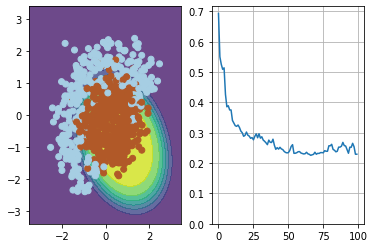

<Figure size 432x288 with 0 Axes>

In [62]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_exp.shape[0], batch_size)
    loss[i] = compute_loss(X_exp, y, w)
    visualize(X_exp[ind,:], y[ind], w, loss)
    
    grad = compute_grad(X_exp[ind,:], y[ind], w)
    g2 = alpha*g2 + (1 - alpha)*(grad**2)
    w = w - eta*grad/(g2+eps)**0.5

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, предлагается реализовать Adam за дополнительные баллы. 

### ADAM (classic)

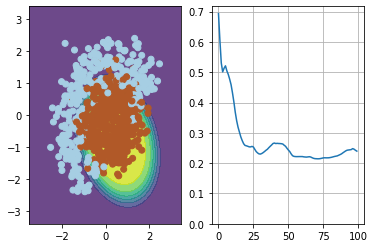

<Figure size 432x288 with 0 Axes>

In [65]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 

betta1 = 0.9
betta2 = 0.99

h = np.zeros_like(w)
g2 = np.zeros_like(w)

eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_exp.shape[0], batch_size)
    loss[i] = compute_loss(X_exp, y, w)
    visualize(X_exp[ind,:], y[ind], w, loss)
    
    grad = compute_grad(X_exp[ind,:], y[ind], w)
    h = betta1*h + (1-betta1)*grad
    g2 = betta2*g2 + (1-betta2)*(grad**2)
    w = w - eta*h/(g2+eps)**0.5

visualize(X, y, w, loss)
plt.clf()